refer: 
1. https://bookdown.org/max/FES/a-simple-example.html
2. https://github.com/Randallzoeng/FES/tree/master/01_Introduction
3. https://github.com/nshahpazov/fes-in-python

In [1]:
import pyreadr
import os

dir_data = os.path.abspath(os.path.dirname(os.getcwd()))

In [2]:
segmentation_rdata = pyreadr.read_r(os.path.join(dir_data,'data/segmentationData.RData'))

In [3]:
df = segmentation_rdata['segmentationData']

In [4]:
df_sample = df.loc[:,['EqSphereAreaCh1', 'PerimCh1', 'Class', 'Case']]
df_sample.columns = ["PredictorA", "PredictorB", "Class", "Case"]

In [5]:
df_sample['mutated_class'] = df_sample['Class'].apply(lambda x:'One' if x=='PS' else 'Two')

In [6]:
example_train = df_sample.loc[df_sample['Case']=='Train',:]
example_test = df_sample.loc[df_sample['Case']=='Test',:]

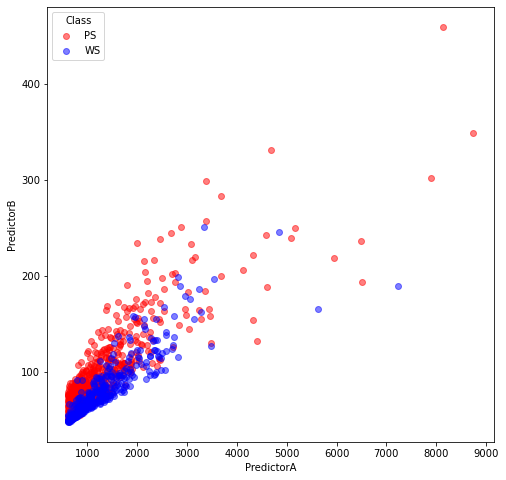

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.scatter(example_train.loc[example_train['mutated_class']=='One','PredictorA'],
            example_train.loc[example_train['mutated_class']=='One','PredictorB'], 
            c='r',alpha=0.5)
plt.scatter(example_train.loc[example_train['mutated_class']=='Two','PredictorA'],
            example_train.loc[example_train['mutated_class']=='Two','PredictorB'], 
            c='b',alpha=0.5)
plt.xlabel('PredictorA')
plt.ylabel('PredictorB')
plt.legend(labels=['PS','WS'],title='Class')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(
    example_train[['PredictorA','PredictorB']],
    example_train['Class'],test_size=0.2,random_state=0,stratify=example_train['Class'])

In [32]:
from sklearn.linear_model import LogisticRegression
import numpy as np

glm = LogisticRegression(random_state=0,fit_intercept=True, penalty='none').fit(X_train,y_train)

beta0, beta1, beta2 = [round(x, 3) for x in np.append(glm.intercept_, glm.coef_)]
print(beta0, beta1, beta2)

1.724 0.003 -0.064


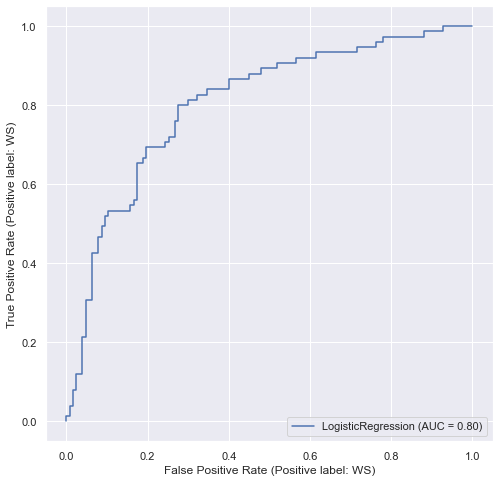

In [33]:
from sklearn.metrics import plot_roc_curve, roc_curve, RocCurveDisplay
fig, ax = plt.subplots(figsize=(8,8))
RocCurveDisplay.from_estimator(glm, X_test, y_test,ax=ax)
plt.show()

[Adjust size of ConfusionMatrixDisplay (ScikitLearn)](https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn)

```py
#Adjust size of RocCurveDisplay
from sklearn import metrics
from sklearn.preprocessing import label_binarize
fpr, tpr, thresholds = metrics.roc_curve(label_binarize(y_test, classes=['PS', 'WS']), clf_glm.decision_function(X_test))
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                    estimator_name='glm')

fig, ax = plt.subplots(figsize=(6,6))
display.plot(ax=ax)
```

In [11]:
from sklearn.preprocessing import PowerTransformer
trans_bc = PowerTransformer(method='box-cox')
trans_bc.fit(example_train[['PredictorA','PredictorB']])
# trans_bc.transform(example_train[['PredictorA','PredictorB']])

PowerTransformer(method='box-cox')

In [29]:
from sklearn.pipeline import Pipeline
glm_on_inverse = Pipeline([
    ('box-cox', trans_bc),
    ('glm', LogisticRegression(fit_intercept=True, penalty='none'))])

glm_on_inverse.fit(X_train, y_train)

Pipeline(steps=[('box-cox', PowerTransformer(method='box-cox')),
                ('glm', LogisticRegression(penalty='none'))])

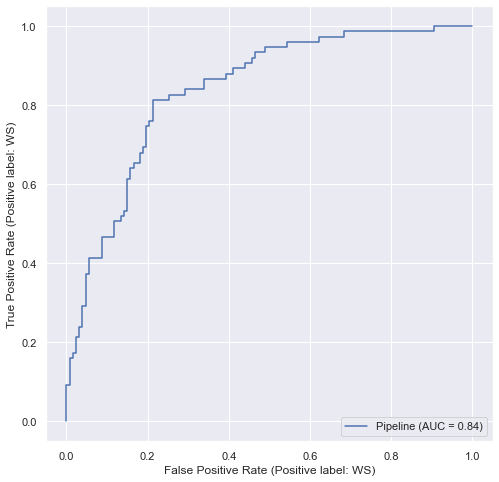

In [30]:
fig, ax = plt.subplots(figsize=(8,8))
RocCurveDisplay.from_estimator(glm_on_inverse, X_test, y_test,ax=ax)
plt.show()

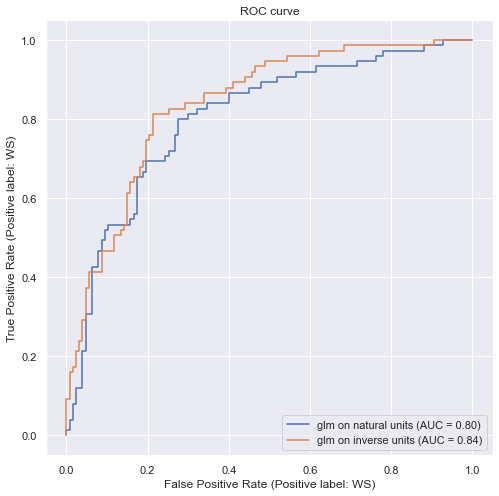

In [43]:
fig, ax = plt.subplots(figsize=(8,8))
models = [("glm on natural units",glm),
          ("glm on inverse units",glm_on_inverse)]

models_displays = {}
for name,pipeline in models:
    models_displays[name] = RocCurveDisplay.from_estimator(
        pipeline,X_test,y_test,ax=ax,name=name)
_ = ax.set_title("ROC curve")
plt.show()